# Deacargar el Dataset 

In [10]:
!kaggle competitions download -c dogs-vs-cats

100%|███████████████████████████████████████▉| 811M/812M [00:14<00:00, 57.9MB/s]
100%|████████████████████████████████████████| 812M/812M [00:14<00:00, 57.6MB/s]


In [4]:
!pip3 install --upgrade pip
!pip3 uninstall tensorflow-gpu -y
!pip3 uninstall tensorflow -y
!pip3 install --upgrade tensorflow
!pip3 install --upgrade tensorflow-gpu

Found existing installation: tensorflow-gpu 2.6.2
Uninstalling tensorflow-gpu-2.6.2:
  Successfully uninstalled tensorflow-gpu-2.6.2
  Using cached tensorflow-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-serving-api 1.15.0 requires tensorflow~=1.15.0, but you have tensorflow 2.6.2 which is incompatible.
  Using cached tensorflow_gpu-2.6.2-cp36-cp36m-manylinux2010_x86_64.whl (458.3 MB)


In [2]:
import numpy as np
import tensorflow as tf
import os, shutil, pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import os, shutil, pathlib


original_dir = pathlib.Path("../train")
new_base_dir = pathlib.Path("../cats_vs_dogs_small")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:',tf.test.gpu_device_name())
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [12]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip
!unzip -qq test1.zip

In [ ]:


def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [15]:
!ls ./train | wc -l

25000


# Creando y compilando una ConvNet

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, )

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856 

In [6]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Dataloader y pre processing

In [7]:

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## Dataset de juguete - Iterando en el dataset

### Ejemplo un dataset a partir de un numpy array

In [9]:
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [10]:
random_numbers.shape

(1000, 16)

In [13]:
print (random_numbers[0])

[-1.00034415 -0.87331905 -1.92196468  1.31751811  0.46313772 -0.39868209
  0.72085286 -0.23661758 -0.2751591   0.96277097  0.62075151 -1.72907632
  0.73309414 -1.01033732  0.54160016  1.63425798]


### Iterando el dataset

In [14]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


### Batching

In [15]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


### Aplicando una transformación del dataset

In [16]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


## Volviendo al dataset original

In [7]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


# Ajustando el modelo

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-02-14 13:08:26.955 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:2483 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-14 13:08:26.980 tensorflow-2-6-gpu--ml-g4dn-xlarge-0201d392adbb6351f674da89d00b:2483 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
63/63 [==============================] - 12s 119ms/step - loss: 0.7816 - accuracy: 0.5185 - val_loss: 0.6909 - val_accuracy: 0.5630
Epoch 2/30
63/63 [==============================] - 4s 55ms/step - loss: 0.6968 - accuracy: 0.5350 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 3/30
63/63 [====

# Loss y accuracy en training

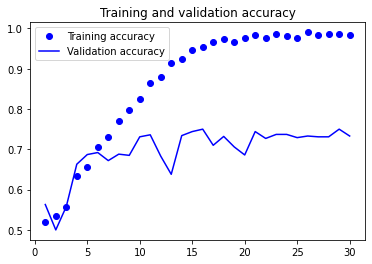

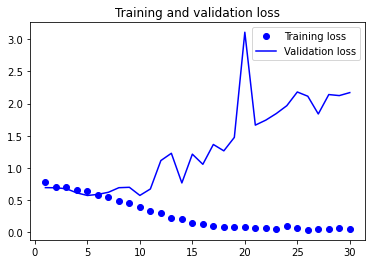

In [9]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Evauacion en el test

In [10]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 28ms/step - loss: 0.5933 - accuracy: 0.6915
Test accuracy: 0.692
